<a href="https://colab.research.google.com/github/Kusuru-Meghana/functional-enrichment/blob/main/functional_enrichment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Functional Enrichment & GSEA for Skeletal Muscle DE Genes**

## Project Overview
The goal of this project is to use a differential expression (DE) results table for **human skeletal muscle** to identify which biological processes and pathways are most implicated. We combine **over-representation analysis (ORA)** using **g:Profiler** and **preranked GSEA** using **GSEApy** to get complementary views of enrichment.

### Why This Matters
Linking gene-level changes to pathways clarifies the biology driving the phenotype (e.g., muscle remodeling, metabolism, inflammation). This surfaces hypotheses, candidate biomarkers, and targets for follow-up experiments, rather than interpreting thousands of genes in isolation.

### Dataset Information
- **Source - ** User-provided DE summary table (e.g., from DESeq2/edgeR/limma).
- **Organism - ** *Homo sapiens* (`hsapiens`).
- **Unit of analysis - ** Gene (one row per gene).
- **Key columns (expected):**
  - `names` — HGNC gene symbol
  - `scores` — ranking metric (e.g., moderated t-statistic or signed log2FC)
  - `pvals` — nominal p-value
  - `pvals_adj` — FDR-adjusted p-value (Benjamini–Hochberg)
- **(Optional)** **N rows - ** _fill in after loading the file_

### Preprocessing
- Drop rows with missing `names` or `scores`.
- Build a seed list for ORA using a dynamic cutoff (tunable):  
  `scores > mean(scores) + 1.5 × sd(scores)` **and** `pvals_adj < 0.05`.
- Keep the full ranked list (`names`, `scores`) for GSEA (no cutoff).

### Aim
- **ORA (g:Profiler) - ** Are GO terms (BP/MF/CC) or pathways (KEGG/Reactome) over-represented among the significant genes?
- **GSEA (GSEApy, preranked) - ** Using all genes ordered by `scores`, which pathways show coherent up- or down-regulation (NES, FDR)?



##Step 1 - Installing & Importing

In [ ]:
!pip install -q gprofiler-official gseapy pandas matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from gprofiler import GProfiler
import gseapy as gsea

sns.set(style="whitegrid", context="notebook")


##Step 2 - Load your DE table & check the data set
Here I’m pulling in the raw results (e.g., expression tables / differential results) so I can work with them in memory. I do a quick sanity check—shapes, column names, a few rows—to confirm everything looks as expected before proceeding.

In [ ]:
import pandas as pd
df = pd.read_csv("/content/skeletal_muscle.csv")

# Converts every column name to lowercase
df.columns = df.columns.str.lower()    # normalize names - Prevents case-sensitivity bugs

# Checks that the DataFrame contains at least those four columns
assert {'names','scores','pvals','pvals_adj'} <= set(df), "Need names/scores/pvals/pvals_adj"  # set(df) is the set of column names -  <= means “is a subset of.”

# Removes rows where names or scores are missing, then makes a fresh copy
df = df.dropna(subset=['names','scores']).copy()           # keep usable rows

# Fast sanity check that values look sensible
df.head(), df[['scores','pvals','pvals_adj']].describe()



(   unnamed: 0 names     scores          pvals      pvals_adj
 0           0  APOD  31.004278  4.720000e-211  9.440000e-208
 1           1   DCN  30.380283  1.000000e-202  2.000000e-199
 2           2   GSN  29.149391  8.500000e-187  1.700000e-183
 3           3   CFD  26.491886  1.200000e-154  2.400000e-151
 4           4   MGP  25.059530  1.370000e-138  2.750000e-135,
              scores          pvals      pvals_adj
 count  24000.000000   2.400000e+04   2.400000e+04
 mean      -0.004099   6.410779e-01   9.564824e-01
 std        2.165261   3.047729e-01   1.998540e-01
 min      -19.866478  4.720000e-211  9.440000e-208
 25%       -0.405033   4.674528e-01   1.000000e+00
 50%       -0.129711   7.493002e-01   1.000000e+00
 75%        0.199584   8.791213e-01   1.000000e+00
 max       31.004278   1.000000e+00   1.000000e+00)

## Step 3 - QC - look at the score distribution
Before picking cutoffs or running enrichment, we want to see the shape of your ranking metri

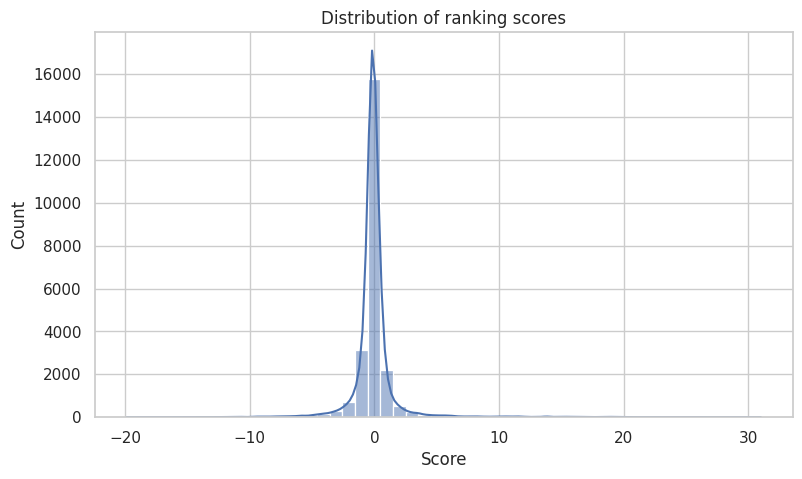

In [ ]:
plt.figure(figsize=(9,5)) # 9 inches wide × 5 inches tall

# Draws a histogram of the scores column with 50 bins and overlays a KDE curve
sns.histplot(df["scores"], bins=50, kde=True)    # Histogram shows how many genes fall into each score range, KDE traces the overall shape (peaks/tails) so you can see skew or multiple modes.
plt.title("Distribution of ranking scores")
plt.xlabel("Score"); plt.ylabel("Count")
plt.show()


##Step 4 - Pick significant genes

Now I define “significant” in a transparent way (eg, adjusted p-value threshold and effect-size/log2FC cutoff) and extract those genes. The goal is to balance sensitivity and specificity so the list is biologically meaningful, not just statistically long

In [ ]:
import pandas as pd
from gprofiler import GProfiler

# Makes sure the three important columns (scores, pvals, pvals_adj) are actually numbers.
df[["scores", "pvals", "pvals_adj"]] = df[["scores", "pvals", "pvals_adj"]].apply(pd.to_numeric, errors="coerce")

# Calculates the average (mean) of all scores and spread (standard deviation) of scores
threshold = df["scores"].mean() + 1.5 * df["scores"].std()
# this threshold helps pick out genes that have unusually high scores (the “standout” genes)

# Filters the table and keeps only the genes that have high score and  q<0.05)
significant = df[(df["scores"] > threshold) & (df["pvals_adj"] < 0.05)][["names","scores","pvals_adj"]]
#this gives you a shortlist of important genes to test for enrichment

# Make a clean unique gene list
gene_list = significant["names"].dropna().astype(str).str.strip().unique().tolist() # Removes missing names - Makes sure they’re strings - Strips spaces (like " ACTN3 " → "ACTN3") - Drops duplicates - Converts into a Python list.
print(f"{len(gene_list)} genes passed the filter (threshold={threshold:.3f})")

# Run g:Profiler enrichment
gp = GProfiler(return_dataframe=True)
go_results = gp.profile(organism="hsapiens", query=gene_list)

# Show first 5 results
print(go_results.head())


321 genes passed the filter (threshold=3.244)
  source      native                            name       p_value  \
0  GO:CC  GO:0005576            extracellular region  5.263725e-35   
1  GO:BP  GO:0001568        blood vessel development  2.293754e-33   
2  GO:BP  GO:0001944         vasculature development  3.252073e-33   
3  GO:CC  GO:0071944                  cell periphery  5.071141e-33   
4  GO:BP  GO:0072359  circulatory system development  7.110476e-33   

   significant                                        description  term_size  \
0         True  "The space external to the outermost structure...       4258   
1         True  "The process whose specific outcome is the pro...        732   
2         True  "The process whose specific outcome is the pro...        762   
3         True  "The broad region around and including the pla...       6347   
4         True  "The process whose specific outcome is the pro...       1145   

   query_size  intersection_size  effective_domain_s

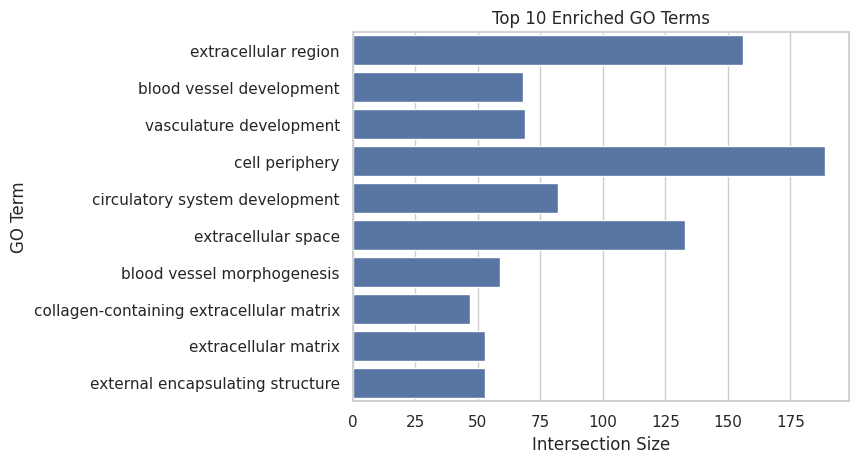

In [ ]:
sns.barplot(x='intersection_size', y='name', data=go_results.head(10))
plt.title('Top 10 enriched GO terms')
plt.xlabel('Intersection Size')
plt.ylabel('GO Term')
plt.show()

## Step 5 - Pathway analysis
Focused specifically on KEGG and Reactome pathways.

- source: which database the term comes from (KEGG or REAC for Reactome).

- native: the pathway’s ID in that database (e.g., KEGG:04510, REAC:R-HSA-1474244).

- name: pathway name (e.g., Extracellular matrix organization).

- description: often repeats the name (some builds include extra text).

- p_value: significance of enrichment (g:Profiler uses a built-in multiple-testing correction by default).

   - smaller is better; typical significance cutoffs are 0.05 or 0.01.

- significant: boolean flag; True means it passed the significance criteria.

- term_size: how many genes are in that pathway in the database.

- query_size: how many genes you submitted (size of gene_list for this query).

- intersection_size: how many of your genes hit this pathway (the overlap).

     - Bigger overlap with a low p-value = stronger evidence.

- effective_domain_size: the background size g:Profiler used when calculating stats (the “universe” of genes).

- precision: intersection_size / query_size → what fraction of your list hits this pathway.

- recall: intersection_size / term_size → what fraction of the pathway you captured.

- query: label for the submitted gene list (useful if you run multiple lists at once).

- parents: the parent term(s) in the hierarchy (more relevant for hierarchical ontologies; Reactome also has parents).

In [ ]:
# perform pathway analysis
pathway_analysis_results = gp.profile( organism='hsapiens',  query=gene_list, sources=["KEGG", "REAC"])

# display the results
print(pathway_analysis_results.head())

  source              native                                name  \
0   REAC  REAC:R-HSA-1474244   Extracellular matrix organization   
1   REAC   REAC:R-HSA-216083  Integrin cell surface interactions   
2   KEGG          KEGG:04510                      Focal adhesion   
3   REAC  REAC:R-HSA-3000178                   ECM proteoglycans   
4   KEGG          KEGG:04512            ECM-receptor interaction   

        p_value  significant                         description  term_size  \
0  3.338399e-13         True   Extracellular matrix organization        298   
1  2.743834e-10         True  Integrin cell surface interactions         84   
2  4.099802e-10         True                      Focal adhesion        202   
3  7.079379e-10         True                   ECM proteoglycans         76   
4  1.028177e-08         True            ECM-receptor interaction         89   

   query_size  intersection_size  effective_domain_size  precision    recall  \
0         220                 33    

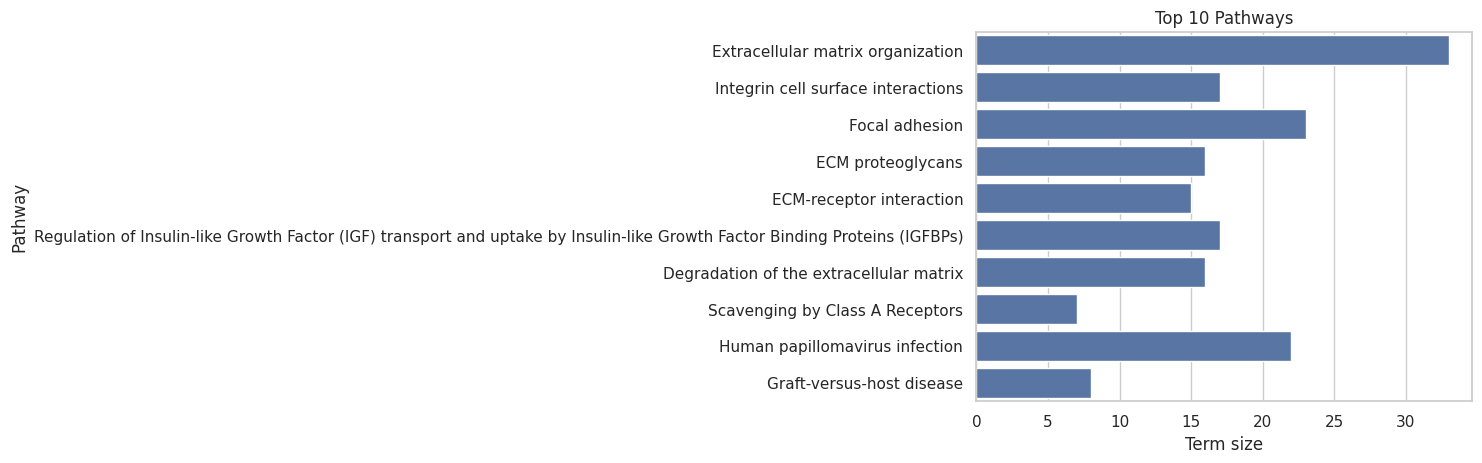

In [ ]:

sns.barplot(x='intersection_size', y='name', data=pathway_analysis_results.head(10))
plt.title('Top 10 Pathways')
plt.xlabel('Term size')
plt.ylabel('Pathway')
plt.show()

## Step 6 - GSEA (Gene Set Enrichment Analysis) using GSEApy

GSEA checks whether genes belonging to the same pathway are clustered near the top or bottom of ranked list, even if they’re not individually significant.

This step takes entire ranked gene list and runs GSEA to find pathways where the genes consistently shift up or down, even if individual genes aren’t very strong. It complements the cutoff-based ORA.

In [ ]:

import pandas as pd
import gseapy as gsea
from gprofiler import GProfiler

# keep g:Profiler separate so it doesn't shadow gseapy
gprof = GProfiler(return_dataframe=True)

# ---- make the ranked list from df ----

rank_df = (
    df.loc[:, ["names", "scores"]]     # take only gene names + scores
      .dropna()                        # remove rows with missing values
      .rename(columns={"names":"Gene","scores":"Score"})
      .drop_duplicates(subset="Gene")  # keep each gene once
      .sort_values("Score", ascending=False)  # sort: high scores on top
      .set_index("Gene")               # make gene names the index
)
# This builds a ranked list = every gene with its score, sorted high → low


# ensure numeric
rank_df["Score"] = pd.to_numeric(rank_df["Score"], errors="coerce")

# run preranked GSEA with gseapy
pre_res = gsea.prerank(
    rnk=rank_df["Score"],     # the ranked list (gene as index, score as value)
    gene_sets="KEGG_2016",    # database of gene sets to test against
    permutation_num=100,      # random shuffles (higher = more accurate, but slower)
    seed=5,                   # for reproducibility
    outdir=None               # don’t save files, just keep results in memory
)

print(pre_res.res2d.head())


2025-08-29 17:32:10,141 [WARNING] Duplicated values found in preranked stats: 8.00% of genes
The order of those genes will be arbitrary, which may produce unexpected results.


      Name                                               Term        ES  \
0  prerank   Hematopoietic cell lineage Homo sapiens hsa04640 -0.869353   
1  prerank  AGE-RAGE signaling pathway in diabetic complic...  0.870689   
2  prerank         Rheumatoid arthritis Homo sapiens hsa05323 -0.804745   
3  prerank  Epstein-Barr virus infection Homo sapiens hsa0...  -0.73694   
4  prerank  Cell adhesion molecules (CAMs) Homo sapiens hs...  -0.77078   

        NES NOM p-val FDR q-val FWER p-val  Tag %  Gene %  \
0 -1.699797       0.0  0.115596       0.07   5/15   1.15%   
1  1.687277       0.0  0.016748       0.02   9/29   5.40%   
2 -1.656942  0.019231  0.127155       0.16  10/19  10.85%   
3 -1.564548  0.043478  0.273576       0.36   5/29   6.65%   
4 -1.532306       0.0  0.303438       0.46  10/16   7.65%   

                                          Lead_genes  
0                  CD36;HLA-DRA;HLA-DRB1;ITGA1;ITGA6  
1  COL1A2;FN1;COL3A1;MMP2;COL1A1;F3;AGTR1;CCL2;TG...  
2  HLA-DRA;HLA-DR